# 치터 판별 XGBoost 모델 학습

Optical Flow로 추출된 프레임 데이터를 전처리하고, **해당 영상의 플레이어가 치터인지 아닌지 판별**하는 XGBoost 이진 분류 모델을 학습

---

### 주요 동작 흐름

1.  **데이터 로드**:
    * 일반 유저와 치터의 데이터가 담긴 Excel 파일을 각각 로드
2.  **데이터 전처리**:
    * 각 데이터에 치트 여부를 나타내는 라벨을 추가
    * 모델 학습에 사용할 주요 특징을 정의
    * 데이터를 학습용과 검증용으로 분할
3.  **XGBoost 모델 학습**:
    * 클래스 불균형 문제를 완화하기 위해 파라미터를 적용
    * 하이퍼파라미터를 설정하고, 모델을 학습
4.  **모델 성능 평가**:
    * 학습된 모델의 성능을 평가

---

### 핵심 포인트

* **입력 데이터**: 각 프레임 단위로 계산된 에임의 위치 변화량, 속도, 가속도 등을 사용
* **특징 정의**: 프레임 데이터를 전처리하여 모델 학습에 사용할 수 있도록 재정의
* **클래스 불균형 처리**: 데이터셋에 치터보다 일반 유저가 훨씬 많기 때문에, 소수 클래스에 더 높은 가중치를 부여하여 모델이 치터 데이터를 더 중요하게 학습하도록 유도

## 라이브러리 설치

In [ ]:
!pip install xgboost==3.0.5 shap pandas scikit-learn openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.0
    Uninstalling xgboost-3.1.0:
      Successfully uninstalled xgboost-3.1.0


In [ ]:
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
from google.colab import drive
from scipy.stats import entropy, randint, uniform

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 로드

In [ ]:
# --- 불러올 데이터의 경로 지정 ---
human_data_path = "/content/drive/MyDrive/Preprocessed_Dataset/aim_analysis_human.xlsx" # 사람 데이터 엑셀 경로 지정
cheat_data_path = "/content/drive/MyDrive/Preprocessed_Dataset/aim_analysis_cheat.xlsx" # 치트 데이터 엑셀 경로 지정

# --- 엑셀 로드 ---
df_human = pd.read_excel(human_data_path)
df_cheat = pd.read_excel(cheat_data_path)

# --- 치트 라벨 추가 ---
df_human['cheat'] = 0 # 사람 데이터프레임에 모든 행에 'cheat' 컬럼을 추가하고 값을 0으로 설정
df_cheat['cheat'] = 1 # 치트 데이터프레임의 모든 행에 'cheat' 컬럼을 추가하고 값을 1로 설정

In [ ]:
# 두 데이터프레임을 하나로 합침
df_concat = pd.concat([df_human, df_cheat], ignore_index=True)

print("--- df_concat 예시 ---")
df_concat.iloc[[0]]

--- df_concat 예시 ---


,filename,frame,dx,dy,velocity,acceleration,jerk,angle_deg,angle_change,cheat
0,videos/01701665-2d22-4a6c-99e0-f36fa91395cf.webm,0,9.003283,-0.420831,9.013113,NaN,NaN,-2.676168,NaN,0


In [ ]:
# 'filename'을 기준으로 데이터를 그룹화
df_grouped = df_concat.groupby('filename')

print(f"총 {len(df_grouped)}개의 고유한 파일이 있습니다.")

총 256개의 고유한 파일이 있습니다.


## 데이터 전처리

In [ ]:
'''
[영상 마다 프레임별로 나뉜 데이터를 묶어야 함]
  * 원본 특징
    : 파일 이름(filename), 프레임(frame), 위치 변화량(dx, dy), 속도(velocity), 가속도(acceleration),
      가가속도(jerk), 각도(angle_deg), 각도 변화량(angle_change), 치트 여부(cheat)

  * 요약 특징
    : 평균(mean), 중앙값(median), 최빈값(mode), 범위(range), 표준편차(std),
      사분위수 범위(IQR), 최댓값(max), 최솟값(min), 왜도(skewness), 첨도(kurtosis),
      영점 교차율(zero-crossing rate), 엔트로피(entropy), 상관계수(correlation)

  데이터 한 묶음  : 150프레임 (30프레임 5초)
  시계열 데이터   : 이전 데이터와 4초(120프레임)씩 겹침 (30초 영상 기준 데이터 26개 생성)
'''

# 파라미터 설정
WINDOW_SIZE = 150  # 150 프레임 (5초)
STEP_SIZE = 30     # 30 프레임 (1초) 만큼 이동 (120 프레임 겹침)
ENTROPY_BINS = 10  # 엔트로피 계산 시 데이터를 나눌 구간(bin) 수

# 요약할 원본 특징 리스트
features_origin_list = ['dx', 'dy', 'velocity', 'acceleration', 'jerk', 'angle_deg', 'angle_change']

# 요약 특징 청크(chunk)를 저장할 리스트
all_video_chunks = []

# 각 영상(파일)별로 반복 처리
for filename, video_data in df_grouped:

    # 해당 영상의 총 프레임 수
    n_frames = len(video_data)

    # 슬라이딩 윈도우 적용
    # 0 프레임부터 (총 프레임 - 윈도우 크기)까지 STEP_SIZE 만큼 이동
    # STEP_SIZE보다 적게 남은 데이터는 버림
    for i in range(0, n_frames - WINDOW_SIZE + 1, STEP_SIZE):

        # 150 프레임으로 구성된 현재 윈도우(청크)를 추출
        chunk = video_data.iloc[i : i + WINDOW_SIZE]

        # 현재 청크의 요약 특징을 저장할 딕셔너리
        summary_stats = {}

        # 기본 정보(파일이름, 치트여부) 추가
        summary_stats['filename'] = filename
        # cheat 값은 윈도우 내에서 동일하므로 첫 번째 값을 사용
        summary_stats['cheat'] = chunk['cheat'].iloc[0]
        summary_stats['start_frame'] = i

        # --- 각 특징별로 요약 특징 계산 ---
        for col in features_origin_list:
            series = chunk[col] # 현재 청크의 해당 특징(Series)

            # --- 요약 특징 계산 ---
            summary_stats[f'{col}_mean'] = series.mean()          # 평균
            summary_stats[f'{col}_median'] = series.median()      # 중앙값

            # mode는 여러 개일 수 있으므로 첫 번째 값만 사용 (없으면 NaN)
            mode_val = series.mode()
            summary_stats[f'{col}_mode'] = mode_val.iloc[0] if not mode_val.empty else np.nan

            s_max = series.max()
            s_min = series.min()
            summary_stats[f'{col}_range'] = s_max - s_min         # 범위
            summary_stats[f'{col}_std'] = series.std()            # 표준편차

            q75 = series.quantile(0.75)
            q25 = series.quantile(0.25)
            summary_stats[f'{col}_iqr'] = q75 - q25               # 사분위수 범위

            summary_stats[f'{col}_max'] = s_max                   # 최댓값
            summary_stats[f'{col}_min'] = s_min                   # 최솟값
            summary_stats[f'{col}_skewness'] = series.skew()      # 왜도
            summary_stats[f'{col}_kurtosis'] = series.kurtosis()  # 첨도

            s_np = series.values
            summary_stats[f'{col}_zcr'] = ((s_np[:-1] * s_np[1:]) < 0).sum() / WINDOW_SIZE  # 영점 교차율

            # 데이터를 구간으로 나눔
            binned_series = pd.cut(series, bins=ENTROPY_BINS, labels=False)
            # 각 구간의 빈도수를 계산
            value_counts = binned_series.value_counts(normalize=True)
            summary_stats[f'{col}_entropy'] = entropy(value_counts)                         # 엔트로피

        # --- 모든 특징 조합의 상관계수 계산 ---
        for feat1, feat2 in itertools.combinations(features_origin_list, 2):
            correlation = chunk[feat1].corr(chunk[feat2])

            # 한쪽 값이 일정(std=0)하면 상관계수가 NaN이 됨 -> 0으로 처리
            if pd.isna(correlation):
                summary_stats[f'corr_{feat1}_{feat2}'] = 0
            else:
                summary_stats[f'corr_{feat1}_{feat2}'] = correlation

        # 완성된 요약 특징 딕셔너리를 리스트에 추가
        all_video_chunks.append(summary_stats)

# 모든 청크 리스트를 하나의 새로운 DataFrame으로 변환
df = pd.DataFrame(all_video_chunks)

In [ ]:
# --- 특징 및 라벨 분리 ---
y = df['cheat']         # 'cheat' 열을 라벨로 사용
groups = df['filename'] # 데이터를 나눌 기준 (파일 이름)
non_feature_cols = ['filename', 'cheat', 'start_frame'] # 특징이 아닌 열들
X = df.drop(columns=non_feature_cols)                   # 구별자를 제외하여 데이터셋 생성

# --- GroupShuffleSplit 설정 ---
# 영상(group)을 기준으로 8:2 분할, 1번만 실행
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# --- 인덱스 분할 ---
# X, y, groups를 넣으면 train/val로 나눌 인덱스를 반환
train_idx, val_idx = next(gss.split(X, y, groups=groups))

# --- 인덱스를 사용해 실제 데이터 분할 ---
X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
X_val = X.iloc[val_idx]
y_val = y.iloc[val_idx]

print("데이터셋 분할이 완료되었습니다:")
print("-" * 30)
print(f"총 데이터 샘플(청크) 수: {len(X)}")
print(f"총 특징(feature) 수: {X.shape[1]}")
print("-" * 30)
print("X_train shape (학습용 특징):", X_train.shape)
print("y_train shape (학습용 라벨):", y_train.shape)
print("X_val shape (검증용 특징):", X_val.shape)
print("y_val shape (검증용 라벨):", y_val.shape)
print("\n--- 학습용(y_train) 라벨 분포 ---")
print(y_train.value_counts(normalize=True))
print("\n--- 검증용(y_val) 라벨 분포 ---")
print(y_val.value_counts(normalize=True))

# --- 데이터 누수 방지 확인 ---
train_files = set(df.iloc[train_idx]['filename'])
val_files = set(df.iloc[val_idx]['filename'])
overlapping_files = train_files.intersection(val_files)

print("\n" + "="*30)
print(f"학습셋 고유 파일 수: {len(train_files)}")
print(f"검증셋 고유 파일 수: {len(val_files)}")
print(f"겹치는 파일 수 : {len(overlapping_files)}")
print("="*30)

데이터셋 분할이 완료되었습니다:
------------------------------
총 데이터 샘플(청크) 수: 5569
총 특징(feature) 수: 105
------------------------------
X_train shape (학습용 특징): (4457, 105)
y_train shape (학습용 라벨): (4457,)
X_val shape (검증용 특징): (1112, 105)
y_val shape (검증용 라벨): (1112,)

--- 학습용(y_train) 라벨 분포 ---
cheat
0    0.915863
1    0.084137
Name: proportion, dtype: float64

--- 검증용(y_val) 라벨 분포 ---
cheat
0    0.841727
1    0.158273
Name: proportion, dtype: float64

학습셋 고유 파일 수: 204
검증셋 고유 파일 수: 51
겹치는 파일 수 : 0


In [ ]:
df.shape    # 데이터 행과 열
df.columns  # 데이터 열 종류
df.info()   # 데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Columns: 108 entries, filename to corr_angle_deg_angle_change
dtypes: float64(105), int64(2), object(1)
memory usage: 4.6+ MB


## XGBoost 모델 학습

In [ ]:
'''
--- 하이퍼파라미터 목록 및 설명 ---

[트리 구조 및 복잡도 제어]
* max_depth (int):
    트리의 최대 깊이. 값이 클수록 모델이 복잡해지고 과적합(Overfitting)될 수 있음 (보통 3 ~ 10)
* min_child_weight (int):
    자식 노드(leaf)에 필요한 최소한의 가중치(샘플 수) 합. 과적합 제어용 (보통 1 ~ 10)
* gamma (float):
    트리 노드를 분할(split)하기 위한 최소 손실 감소 값. 이 값보다 손실이 적게 감소하면 분할하지 않음. 보수적인 모델링에 사용 (보통 0 ~ 0.5)

[부스팅 및 학습 과정 제어]
* learning_rate (float):
    학습률 (eta). 각 트리의 학습 기여도를 줄여서 과적합을 방지 (보통 0.01 ~ 0.2)
* n_estimators (int):
    생성할 트리의 총 개수 (부스팅 라운드 횟수)

[샘플링 및 과적합 방지]
* subsample (float):
    각 트리 학습 시 무작위로 샘플링할 훈련 데이터의 비율 (0.5 ~ 1.0)
* colsample_bytree (float):
    각 트리 학습 시 무작위로 샘플링할 특징(컬럼)의 비율 (0.5 ~ 1.0)
* colsample_bylevel (float):
    각 트리의 레벨(깊이)별로 무작위로 샘플링할 특징의 비율
* colsample_bynode (float):
    각 트리의 노드(분기)별로 무작위로 샘플링할 특징의 비율

[정규화(Regularization)]
* reg_alpha (float) (L1 정규화):
    L1 정규화(Lasso) 항. 가중치의 절댓값에 페널티를 주어 일부 특징의 가중치를 0으로 만들 수 있음 (특징 선택 효과)
* reg_lambda (float) (L2 정규화):
    L2 정규화(Ridge) 항. 가중치의 제곱에 페널티를 주어 가중치 크기를 전반적으로 줄임

[불균형 데이터셋 처리]
* scale_pos_weight (float):
    클래스 불균형 처리용. 양성 클래스(1)에 부여할 가중치 비율. (음성 샘플 수 / 양성 샘플 수)로 주로 설정
'''

# --- 클래스 불균형 고려 ---
# 불균형 데이터셋에서 소수 클래스(치터=1)에 더 많은 가중치를 부여
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)

print(f"클래스 불균형 비율 (scale_pos_weight): {scale_pos_weight:.2f}")


# --- 하이퍼파라미터 최적값 탐색 (RandomizedSearchCV) ---

# 기본 모델 정의
# 고정할 파라미터들 (목적함수, 평가 지표, 불균형 처리 등)
base_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc", # RandomizedSearchCV의 scoring과 별개로, 내부 평가용
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# 탐색할 파라미터 범위 정의
param_dist = {
    'n_estimators': randint(200, 1000),        # 200 ~ 1000개 사이의 트리 개수
    'learning_rate': uniform(0.01, 0.2),       # 0.01 ~ 0.2 사이의 학습률
    'max_depth': randint(3, 10),               # 3 ~ 9 사이의 최대 깊이
    'min_child_weight': randint(1, 10),        # 1 ~ 9 사이의 최소 가중치
    'gamma': uniform(0, 0.5),                  # 0 ~ 0.5 사이의 감마값
    'subsample': uniform(0.6, 0.4),            # 0.6 ~ 1.0 (0.6 + 0.4) 사이의 샘플 비율
    'colsample_bytree': uniform(0.6, 0.4)      # 0.6 ~ 1.0 (0.6 + 0.4) 사이의 특징 비율
}

# RandomizedSearchCV 설정
# n_iter: 랜덤하게 몇 개의 조합을 시도할지 (횟수가 많을수록 좋은 조합을 찾을 확률이 높음)
# cv: 교차 검증(Cross-Validation) 폴드 수
# scoring: 최적화할 성능 지표. 불균형 데이터이므로 'roc_auc'
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=100,  # 100번의 랜덤 조합을 테스트 (시간이 오래 걸리면 50 정도로 줄이세요)
    cv=5,        # 5-fold 교차 검증
    scoring='roc_auc',
    verbose=2,   # 학습 과정을 자세히 출력
    random_state=42,
    n_jobs=-1
)

print("\n" + "하이퍼파라미터 탐색을 시작합니다...")

# --- 모델 학습 ---
# X_train, y_train을 사용하여 최적의 파라미터 조합을 탐색
random_search.fit(X_train, y_train)

# --- 결과 확인 ---
print("\n" + "="*30)
print("하이퍼파라미터 탐색 완료!")
print(f"최고의 ROC-AUC 점수: {random_search.best_score_:.4f}")
print("최적의 하이퍼파라미터:")
print(random_search.best_params_)
print("="*30)

# --- 최적의 모델 저장 ---
model = random_search.best_estimator_

클래스 불균형 비율 (scale_pos_weight): 10.89

하이퍼파라미터 탐색을 시작합니다...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

하이퍼파라미터 탐색 완료!
최고의 ROC-AUC 점수: 0.9829
최적의 하이퍼파라미터:
{'colsample_bytree': np.float64(0.987032220608099), 'gamma': np.float64(0.27398594162404366), 'learning_rate': np.float64(0.09469418846162371), 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 298, 'subsample': np.float64(0.7650470707645706)}


In [ ]:
# --- 모델을 저장할 경로 지정 ---
model_save_path = "/content/drive/MyDrive/Preprocessed_Dataset/"
model_name = "xgboost_cheater_detection_model.json"
full_model_path = os.path.join(model_save_path, model_name)

# --- 모델 저장 ---
os.makedirs(model_save_path, exist_ok=True)
model.save_model(full_model_path)

print(f"모델이 성공적으로 저장되었습니다.")
print(f"저장 경로: {full_model_path}")

모델이 성공적으로 저장되었습니다.
저장 경로: /content/drive/MyDrive/Preprocessed_Dataset/xgboost_cheater_detection_model.json


## 모델 성능 평가

In [ ]:
# --- 예측값 생성 ---
# predict() : 클래스(0 또는 1)를 예측 (정확도, 혼동 행렬, 분류 리포트용)
y_pred = model.predict(X_val)

# predict_proba() : 클래스별 확률을 예측. [:, 1]은 양성(1) 클래스 확률 (AUC용)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# --- 정확도 (Accuracy) ---
print("--- 정확도 (Accuracy) ---")
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

--- 정확도 (Accuracy) ---
Accuracy: 0.9541


--- 혼동 행렬 (Confusion Matrix) ---


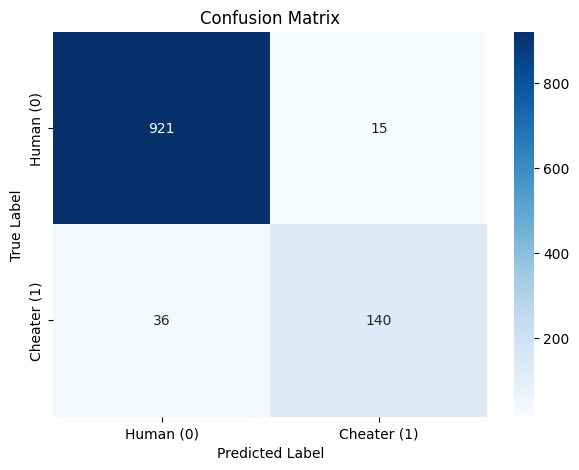

In [ ]:
# --- 혼동 행렬 (Confusion Matrix) ---
print("--- 혼동 행렬 (Confusion Matrix) ---")
cm = confusion_matrix(y_val, y_pred)

# Seaborn을 사용한 히트맵 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            # 0: Human, 1: Cheater
            xticklabels=['Human (0)', 'Cheater (1)'],
            yticklabels=['Human (0)', 'Cheater (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# --- 분류 리포트 (Classification Report) ---
print("\n--- 분류 리포트 (Classification Report) ---")
# 정밀도(Precision), 재현율(Recall), F1-Score 등을 한 번에 보여줌
report = classification_report(y_val, y_pred, target_names=['Human (0)', 'Cheater (1)'])
print(report)


--- 분류 리포트 (Classification Report) ---
              precision    recall  f1-score   support

   Human (0)       0.96      0.98      0.97       936
 Cheater (1)       0.90      0.80      0.85       176

    accuracy                           0.95      1112
   macro avg       0.93      0.89      0.91      1112
weighted avg       0.95      0.95      0.95      1112




--- ROC-AUC 점수 및 곡선 ---
ROC-AUC: 0.9878
PR-AUC : 0.9236



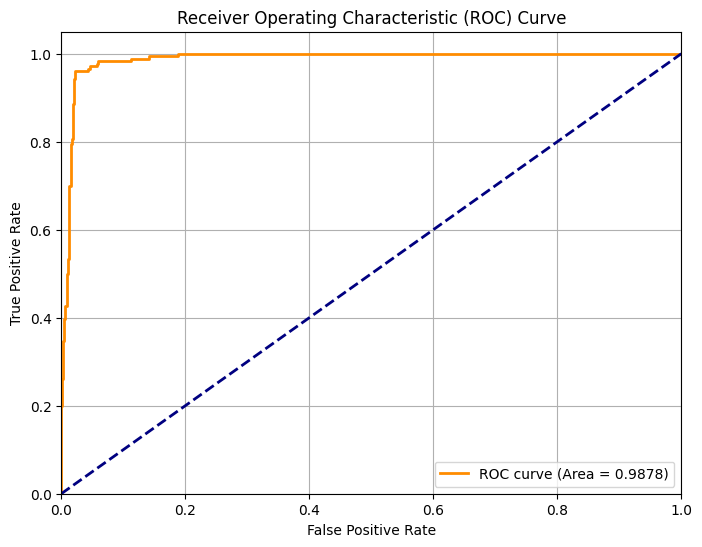

In [ ]:
# --- ROC-AUC 점수 및 곡선 ---
print("\n--- ROC-AUC 점수 및 곡선 ---")

# --- ROC-AUC 점수 ---
roc_auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC : {pr_auc:.4f}\n")

# --- ROC-AUC 곡선 ---
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 50% 수준의 랜덤 모델
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 정밀도 임계값 찾기

--- 임계값(Threshold)별 정밀도 및 FP 확인 ---

[결과]
False Positive를 0으로 만드는 최적 임계값: 0.9989
  -> 이 때의 정밀도 (Precision): 1.0
  -> 이 때의 재현율 (Recall): 0.1989 (즉, 전체 치터 중 19.89% 만 적발)

--- 새로운 임계값 적용 시 혼동 행렬 ---


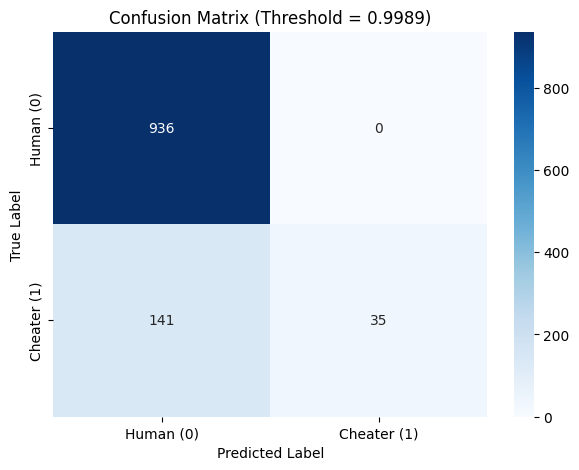


--- 높은 임계값(≈ 정밀도 1.0) 적용 시 성능 ---
              precision    recall  f1-score   support

   Human (0)       0.87      1.00      0.93       936
 Cheater (1)       1.00      0.20      0.33       176

    accuracy                           0.87      1112
   macro avg       0.93      0.60      0.63      1112
weighted avg       0.89      0.87      0.84      1112



In [ ]:
# --- 정밀도-재현율 곡선 계산 ---
# thresholds[0]은 1.0이므로 제외하고 계산
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)

print("--- 임계값(Threshold)별 정밀도 및 FP 확인 ---")

best_threshold = 0.5
best_recall_at_near_perfect_precision = 0.0

# 0.5부터 1.0에 가까운 값까지 임계값을 높여가며 테스트
# thresholds 배열은 0.0 ~ 1.0 사이의 값이 정렬되어 있음
for i in range(len(thresholds)):
    # 현재 임계값
    threshold = thresholds[i]

    # 이 임계값에서의 정밀도(Precision)
    precision = precisions[i]

    # 이 임계값에서의 재현율(Recall)
    recall = recalls[i]

    # FP = 0 (정밀도 >= 0.9999)인 지점 찾기
    if precision >= 0.9999: # 거의 1.0 (FP=0)
        # FP = 0이면서 재현율이 가장 높은(치터를 가장 많이 잡는) 임계값을 저장
        if recall > best_recall_at_near_perfect_precision:
            best_recall_at_near_perfect_precision = recall
            best_threshold = threshold

# 마지막 precision 값(항상 1.0)도 확인 필요 (thresholds 배열에는 없는 임계값에 해당)
if precisions[-1] >= 0.9999:
     recall = recalls[-1]
     if recall > best_recall_at_near_perfect_precision:
         best_recall_at_near_perfect_precision = recall
         # 이 경우 임계값은 thresholds의 마지막 값보다 크거나 같음 (거의 1.0)
         if len(thresholds) > 0:
              best_threshold = thresholds[-1] # 가능한 가장 높은 임계값 사용

print(f"\n[결과]")
print(f"False Positive를 0으로 만드는 최적 임계값: {best_threshold:.4f}")
print(f"  -> 이 때의 정밀도 (Precision): 1.0")
print(f"  -> 이 때의 재현율 (Recall): {best_recall_at_near_perfect_precision:.4f} (즉, 전체 치터 중 {best_recall_at_near_perfect_precision*100:.2f}% 만 적발)")

# --- 해당 임계값으로 새로운 예측 생성 및 혼동 행렬 확인 ---
print("\n--- 새로운 임계값 적용 시 혼동 행렬 ---")
new_y_pred = (y_pred_proba >= best_threshold).astype(int)

cm_new = confusion_matrix(y_val, new_y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human (0)', 'Cheater (1)'],
            yticklabels=['Human (0)', 'Cheater (1)'])
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.4f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- 높은 임계값(≈ 정밀도 1.0) 적용 시 성능 ---")
print(classification_report(y_val, new_y_pred, target_names=['Human (0)', 'Cheater (1)']))


총 6개의 영상에서 높은 임계값 예측 기준 TP 조각 발견.

--- 최종 조정 후 성능 ---

Final Adjusted Accuracy: 0.9604

Final Adjusted Confusion Matrix:


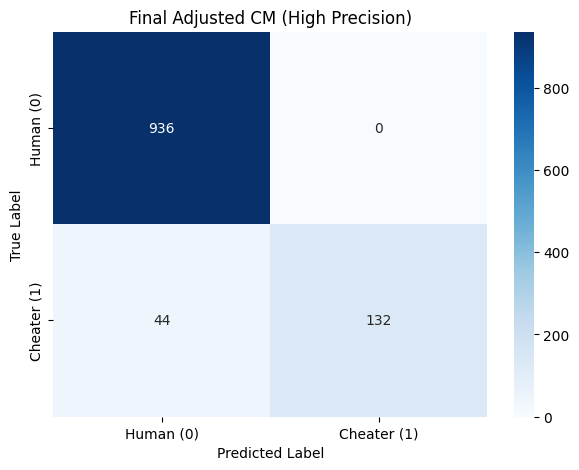


Final Adjusted Classification Report:
              precision    recall  f1-score   support

   Human (0)       0.96      1.00      0.98       936
 Cheater (1)       1.00      0.75      0.86       176

    accuracy                           0.96      1112
   macro avg       0.98      0.88      0.92      1112
weighted avg       0.96      0.96      0.96      1112



In [26]:
# --- 검증 데이터셋의 파일명 정보 가져오기 ---
val_filenames = df.iloc[val_idx]['filename']

# --- 평가용 DataFrame 생성 ---
eval_df = pd.DataFrame({
    'true_label': y_val.values,
    'pred_orig': y_pred,                # 임계값 0.5 기준 예측 (참고용)
    'pred_high_precision': new_y_pred,  # 높은 정밀도 임계값 기준 예측
    'filename': val_filenames.values
})

# True Positive 조건: 실제 라벨(true_label)이 1이고, 높은 임계값 예측(pred_high_precision)도 1인 경우
tp_mask_high_precision = (eval_df['true_label'] == 1) & (eval_df['pred_high_precision'] == 1)
tp_video_set_high_precision = set(eval_df.loc[tp_mask_high_precision, 'filename'])
print(f"\n총 {len(tp_video_set_high_precision)}개의 영상에서 높은 임계값 예측 기준 TP 조각 발견.")

# --- 최종 예측 조정 ---
# 기본값은 높은 정밀도 예측값 사용
eval_df['pred_final_adjusted'] = eval_df['pred_high_precision']

# 높은 임계값 예측에서 TP가 있었던 영상의 모든 조각을 치터(1)로 변경
mask_to_force_cheater_final = eval_df['filename'].isin(tp_video_set_high_precision)
eval_df.loc[mask_to_force_cheater_final, 'pred_final_adjusted'] = 1

# 최종 조정된 예측값
y_pred_final_adjusted = eval_df['pred_final_adjusted']

# --- 최종 조정 결과 평가 ---
print("\n--- 최종 조정 후 성능 ---")

# --- 정확도 ---
accuracy_final_adjusted = accuracy_score(eval_df['true_label'], y_pred_final_adjusted)
print(f"\nFinal Adjusted Accuracy: {accuracy_final_adjusted:.4f}")

# --- 혼동 행렬 ---
print("\nFinal Adjusted Confusion Matrix:")
cm_final_adjusted = confusion_matrix(eval_df['true_label'], y_pred_final_adjusted)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_final_adjusted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human (0)', 'Cheater (1)'],
            yticklabels=['Human (0)', 'Cheater (1)'])
plt.title(f'Final Adjusted CM (High Precision)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- 분류 리포트 ---
print("\nFinal Adjusted Classification Report:")
report_final_adjusted = classification_report(eval_df['true_label'], y_pred_final_adjusted, target_names=['Human (0)', 'Cheater (1)'])
print(report_final_adjusted)